
Problem Statement: Multi-Layer Perceptron (MLP) Implementation using Keras on MNIST Dataset

Dataset

Description

The dataset contains 60,000 Handwritten digits as training samples and 10,000 Test samples, which means each digit occurs 6000 times in the training set and 1000 times in the testing set. (approximately).
Each image is Size Normalized and Centered
Each image is 28 X 28 Pixel with 0-255 Gray Scale Value.
That means each image is represented as 784 (28 X28) dimension vector where each value is in the range 0- 255.

History


Yann LeCun (Director of AI Research, Facebook, Courant Institute, NYU) was given the task of identifying the cheque numbers (in the 90’s) and the amount associated with that cheque without manual intervention. That is when this dataset was created which raised the bars and became a benchmark.

Yann LeCun and Corinna Cortes (Google Labs, New York) hold the copyright of MNIST dataset, which is a subset of the original NIST datasets. This dataset is made available under the terms of the Creative Commons Attribution-Share Alike 3.0 license.

It is the handwritten digits dataset in which half of them are written by the Census Bureau employees and remaining by the high school students. The digits collected among the Census Bureau employees are easier and cleaner to recognize than the digits collected among the students.




In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from time import time

In [1]:
# From keras datasets download mnist images dataset
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

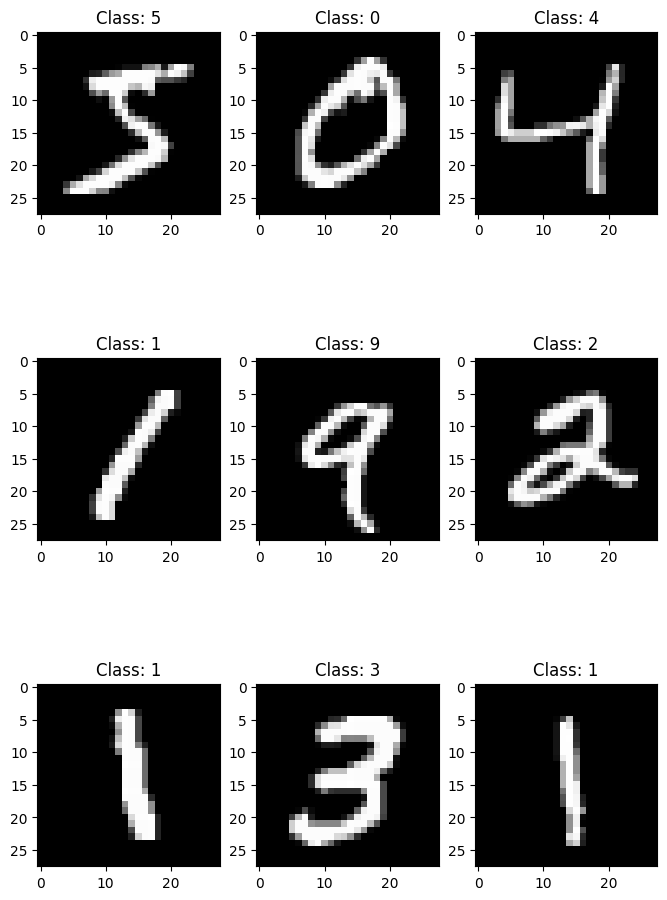

In [5]:
fig,axes = plt.subplots(3,3,figsize=(8,12))
ax = axes.ravel()

for i in range(9):
    ax[i].imshow(train_images[i].reshape(28,28), cmap ='gray')
    ax[i].title.set_text('Class: ' + str(train_labels[i]))

In [6]:
# Each image in the MNIST dataset is represented as a 28x28x1 (height x width x gray scale image) image
# but in order to apply a neural network we must
# first "flatten" the image to be a list of 28x28=784 pixels
# Reshape the train and test images
train_images = train_images.reshape((train_images.shape[0], 28 * 28 * 1)) # 60000, 784
test_images = test_images.reshape((test_images.shape[0], 28 * 28 * 1))    # 10000, 784

In [7]:
train_images.shape, test_images.shape

((60000, 784), (10000, 784))

In [8]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [10]:
pip install keras.utils

  Preparing metadata (setup.py) ... done
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2631 sha256=08b95f2dd8384704f154e6c45764288d7dbe43aef6c0a2be107f23bd76c2190b
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras.utils


In [21]:
!apt install np_utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package np_utils


In [23]:
# 'to_categorical' converts a class vector (integers) to binary class matrix. E.g. for use with categorical_crossentropy.
# y (labels): class vector to be converted into a matrix (integers from 0 to num_classes) to one-hot vector.

from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

Each pixel in the MNIST dataset has an integer label in the range [0, 9], one for each of the possible ten digits in the MNIST dataset. A label with a value of 0 indicates that the corresponding image contains a zero digit. Similarly, a label with a value of 8 indicates that the corresponding image contains the number eight.

However, we first need to transform these integer labels into vector labels, where the index in the vector for label is set to 1 and 0 otherwise (this process is called one-hot encoding).

For example, consider the label 3 and we want to binarize/one-hot encode it — the label 3 now becomes [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]. Notice how only the index for the digit three is set to one — all other entries in the vector are set to zero.

An MLP is composed of

* one (passthrough) **input layer**,
* one or more layers **hidden layers**, and
* one final layer called the **output layer** as shown in the figure below.

The layers close to the input layer are usually called the lower layers, and the ones close to the outputs are usually called the upper layers. Every layer except the output layer includes a **bias neuron** and is fully connected to the next layer.
<br><br>

<center>
<img src="https://www.oreilly.com/api/v2/epubs/9781492037354/files/assets/mlst_1007.png" width= 600px/>
</center>
<br>

MLPs are trained using **backpropagation training algorithm**.

In short, it is Gradient Descent using an efficient technique for computing the gradients automatically: in just two passes through the network (one forward, one backward), the backpropagation algorithm is able to compute the gradient of the network’s error with regard to every single model parameter.

In other words, it can find out how each connection weight and each bias term should be tweaked in order to reduce the error. Once it has these gradients, it just performs a regular Gradient Descent step, and the whole process is repeated until the network converges to the solution.

Let’s run through this algorithm in detail:

* It handles one mini-batch at a time (say, containing 32 instances each), and it goes through the full training set multiple times. Each pass is called an **epoch**.

* Each mini-batch is passed to the network’s **input layer**, which sends it to the first **hidden layer**. The algorithm then computes the output of all the neurons in this layer (for every instance in the mini-batch). The result is passed on to the next layer, its output is computed and passed to the next layer, and so on until we get the output of the last layer, the **output layer**. This is the **forward pass**: it is exactly like making predictions, except all intermediate results are preserved since they are needed for the backward pass.

* Next, the algorithm measures the network’s output error (i.e., it uses a loss function that compares the desired output and the actual output of the network, and returns some measure of the error).

* Then it computes how much each output connection contributed to the error.
This is done analytically by applying the chain rule, which makes this step fast and precise.

* The algorithm then measures how much of these error contributions came from
each connection in the layer below, again using the chain rule, working backward
until the algorithm reaches the input layer. As explained earlier, this reverse pass efficiently measures the error gradient across all the connection weights in the network by propagating the error gradient backward through the network.

* Finally, the algorithm performs a Gradient Descent step to tweak all the connection weights in the network, using the error gradients it just computed.

Let's summarize this algorithm again: for each training instance, the backpropagation algorithm first makes a prediction (**forward pass**) and measures the error, then goes through each layer in reverse to measure the error contribution from each connection (**reverse pass**), and finally tweaks the connection weights to reduce the error (Gradient Descent step).

In order for this algorithm to work properly, the step function was replaced with an activation function.

### Activation Functions

Some of the activation functions are shown below:

* **Logistic (sigmoid) function:**

$$σ(z) = \frac{1}{1 + exp(–z)}$$

It is an S-shaped function, exists between $0$ to $1$. Therefore, it is especially used for models where we have to predict the probability as an output. The function is differentiable.
That means, we can find the slope of the sigmoid curve at any two points.

* **Hyperbolic tangent function:**

$$tanh(z) = 2σ(2z) – 1 = \frac{2}{1 + exp(–2z)} - 1$$

Just like the logistic function, this activation function is S-shaped, continuous, and differentiable, but its output value ranges from $–1$ to $1$. That range tends to make each layer’s output more or less centered around $0$ at the beginning of training, which often helps speed up convergence.

* **Rectified Linear Unit function:**

$$ReLU(z) = max(0, z)$$

The ReLU function is continuous but unfortunately not differentiable at $z = 0$
(the slope changes abruptly, which can make Gradient Descent bounce around),
and its derivative is $0$ for $z < 0$. In practice, however, it works very well and has the advantage of being fast to compute, so it has become the default. Most importantly, the fact that it does not have a maximum output value helps reduce some issues during Gradient Descent.

These popular activation functions and their derivatives are represented in
the figure below.
<br><br>
<center>
<img src="https://www.oreilly.com/api/v2/epubs/9781492037354/files/assets/mlst_1008.png" width=800px/>
</center>
<br><br>

**Why do we need activation functions?**

If we chain several linear transformations, all we get is a linear transformation. For example, if $f(x) = 2x + 3$ and $g(x) = 5x – 1$, then chaining these two linear functions gives you another linear function: $f(g(x)) = 2(5x – 1) + 3 = 10x + 1.$

So if we don’t have some nonlinearity between layers, then even a deep stack of layers is equivalent to a single layer, and we can’t solve very complex problems with that. Conversely, a large enough DNN with nonlinear activations can theoretically approximate any continuous function.


### MLP Classifiers

MLPs can be used for classification and regression tasks. In classification, they can perform (i) Binary Classification (ii) Multilabel Binary Classification, and (iii) Multiclass classification

* **Binary classification:** Used when there are only two distinct classes and the data we want to classify belongs exclusively to one of those classes, e.g. classifying if a review sentiment is positive or negative.

* **Multilabel binary classification:** Used when there are two or more classes and the data we want to classify belongs to none of the classes or all of them at the same time, e.g. classifying which traffic signs are shown in an image.

  Note that the output probabilities do not necessarily add up to 1. This lets the model output any combination of labels

* **Multiclass classification:** Used when there are three or more classes and the data we want to classify belongs exclusively to one of those classes, e.g.  out of three or more possible classes (e.g., classes 0 through 9 for digit image classification), we need to have one output neuron per class, and we should use the **softmax activation function** for the whole output layer as shown in the figure below. The softmax function will ensure that all the estimated probabilities are between $0$ and $1$ and that they add up to $1$.
<br><br>
<center>
<img src="https://www.oreilly.com/api/v2/epubs/9781492037354/files/assets/mlst_1009.png" width=600px/>
</center>

Regarding the loss function, since we are predicting probability distributions, the cross-entropy loss (also called the log loss) is generally a good choice.

### Building an Image Classifier Using the Sequential API



The Sequential function initializes a linear stack of layers which allows to add more layers later using the Dense module.

**Dense** layers are "fully connected" layers. In a dense layer, all nodes in the previous layer connect to the nodes in the current layer.


**Sequential model** is the easiest way to build a model in Keras. It allows us to build a model layer by layer. Each layer has weights that correspond to the layer that follows it. This is called the Sequential API.  We use the ‘add()’ function to add layers to our model. We will add two layers and an output layer.

For more details on Sequential API refer to the following [Documentation](https://keras.io/models/sequential/
)

In [26]:
from keras.layers import Dense, Flatten # Dense layers are "fully connected" layers
from keras.models import Sequential # Importing sequential model

# Flatten the image dimension to pass through the network
image_size = 784 # 28*28

# Create an instance for the sequential model
model = Sequential()

In [27]:
# Create model with 2 hidden layers and one output layer

model.add(Dense(256, activation='relu', input_shape=(image_size,))) # first fully connected layer in the network

model.add(Dense(128, activation="relu")) # second fully connected layer in the network

# The last layer is the output layer. It only has one node, which is for our prediction.
# Output layer - 10 output classes,  softmax activation to obtain the normalized class probabilities for each prediction.
model.add(Dense(10, activation='softmax'))

Let’s go through the above code line by line:


* We first Flatten the image dimension whose role is to convert each input image into a 1D array: if it receives input data X, it computes X.reshape(-1, 1). We can specify it using the 'input_shape' parameter while adding the first Dense hidden layer with 256 neurons.

* Next, it will use the ReLU activation function. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron). When it receives some input data, it computes $h_{W, b}(X) = ϕ( XW + b)$.

* Then we add a second Dense hidden layer with 128 neurons, also using the ReLU
activation function.

* Finally, we add a Dense output layer with 10 neurons (one per class), using the softmax activation function (because the classes are exclusive). Softmax is a sigmoid function applied to an independent variable with more than two categories.

* Softmax makes the output sum up to 1 so the output can be interpreted as probabilities. The model will then make its prediction based on which has a higher probability.

Instead of adding the layers one by one we can pass a list of layers when creating the Sequential model:


In [28]:
# Summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               200960    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1290      
                                                                 
Total params: 235146 (918.54 KB)
Trainable params: 235146 (918.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer="sgd",  metrics=['accuracy'])

In the above code cell,

* first, we use the **"categorical_crossentropy"** loss because we have more than two label classes. Here, we have one target probability per class for each instance (such as one-hot vectors, e.g. [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3). If we were doing binary classification (with one or more binary labels), then we would use the "sigmoid" activation function in the output layer instead of the "softmax" activation function, and we would use the "binary_crossentropy" loss.

* Regarding the optimizer, **"sgd"** means that we will train the model using simple Stochastic Gradient Descent.

* Finally, since this is a classifier, it’s useful to measure its **"accuracy"** during training and evaluation.

In [30]:
# Training model on Training set
history = model.fit(train_images, train_labels, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
1500/1500 [==============================] - 9s 4ms/step - loss: 0.6396 - accuracy: 0.8362 - val_loss: 0.3273 - val_accuracy: 0.9085
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.3035 - accuracy: 0.9133 - val_loss: 0.2534 - val_accuracy: 0.9261
Epoch 3/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2489 - accuracy: 0.9289 - val_loss: 0.2196 - val_accuracy: 0.9376
Epoch 4/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2137 - accuracy: 0.9390 - val_loss: 0.1958 - val_accuracy: 0.9468
Epoch 5/10
1500/1500 [==============================] - 12s 8ms/step - loss: 0.1873 - accuracy: 0.9466 - val_loss: 0.1773 - val_accuracy: 0.9501
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.1662 - accuracy: 0.9521 - val_loss: 0.1607 - val_accuracy: 0.9547
Epoch 7/10
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1491 - accuracy: 0.9570 - val_loss: 0.1469 - val_accurac

The `fit()` method returns a History object containing the training parameters
(`history.params`), the list of epochs it went through (`history.epoch`), and most importantly a dictionary (`history.history`) containing the loss and extra metrics it measured at the end of each epoch on the training set. Keras does backpropagation automatically by using the fit method

Let's plot the learning curves:

In [34]:
history.history

{'loss': [0.6396449208259583,
  0.30348366498947144,
  0.248850479722023,
  0.2136724293231964,
  0.18734340369701385,
  0.1662359982728958,
  0.14914408326148987,
  0.1351291537284851,
  0.12313646078109741,
  0.11318440735340118],
 'accuracy': [0.8362083435058594,
  0.9133124947547913,
  0.9288541674613953,
  0.9389583468437195,
  0.9466458559036255,
  0.9520833492279053,
  0.9569791555404663,
  0.9620000123977661,
  0.9645833373069763,
  0.9670416712760925],
 'val_loss': [0.32729455828666687,
  0.2533758282661438,
  0.2195904403924942,
  0.19577516615390778,
  0.17733386158943176,
  0.16071538627147675,
  0.14690525829792023,
  0.13781364262104034,
  0.12979361414909363,
  0.12351559102535248],
 'val_accuracy': [0.9085000157356262,
  0.9260833263397217,
  0.937583327293396,
  0.9468333125114441,
  0.950083315372467,
  0.9546666741371155,
  0.9584166407585144,
  0.9620833396911621,
  0.9645000100135803,
  0.9651666879653931]}

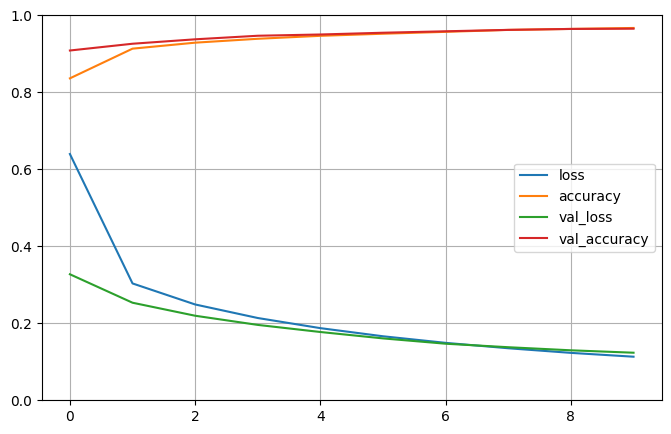

In [35]:
# Visualize training and validation metrics
df = pd.DataFrame(history.history)
df.plot(figsize=(8, 5))
plt.grid(True)

# Set the vertical range to [0-1]
plt.gca().set_ylim(0, 1)
plt.show()

We can see that both the training accuracy and the validation accuracy steadily
increase during training, while the training loss and the validation loss decrease. Moreover, the validation curves are close to the training curves, which means that there is not too much overfitting.

Once we are satisfied with the model’s validation accuracy, we should evaluate it on the test set to estimate the generalization error before we deploy the model to production. We can easily do this using the `evaluate()` method:

In [36]:
# Model performance on test set
model.evaluate(test_images, test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.1197 - accuracy: 0.9646


[0.11973782628774643, 0.9646000266075134]